# 风格迁移的实现

本文件是集智学园开发的“火炬上的深度学习”课程的配套源代码。我们讲解了Prisma软件实现风格迁移的实现原理

在这节课中，我们将学会玩图像的风格迁移。



我们需要准备两张图像，一张作为化作风格，一张作为图像内容

同时，在本文件中，我们还展示了如何实用GPU来进行计算 

本文件是集智学园http://campus.swarma.org 出品的“火炬上的深度学习”第IV课的配套源代码

In [1]:
#导入必要的包
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

# 是否用GPU计算，如果检测到有安装好的GPU，则利用它来计算
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

## 一、准备输入文件

我们需要准备两张同样大小的文件，一张作为风格，一张作为内容

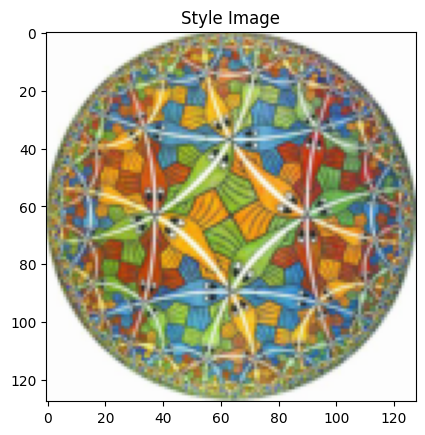

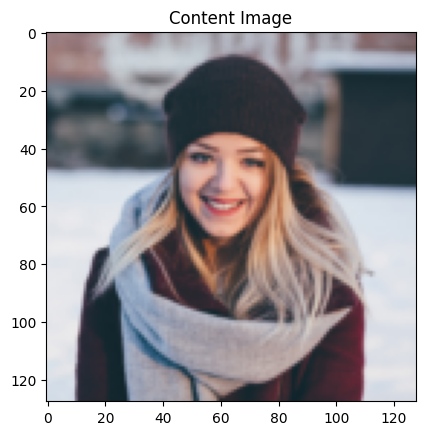

In [2]:
#风格图像的路径,自行设定
style = 'images/escher.jpg'

#内容图像的路径，自行设定
content = 'images/portrait1.jpg'

#风格损失所占比重
style_weight=1000

#内容损失所占比重
content_weight=1

#希望得到的图片大小（越大越清晰，计算越慢）
imsize = 128

loader = transforms.Compose([
    transforms.Resize(imsize),  # 将加载的图像转变为指定的大小
    transforms.ToTensor()])  # 将图像转化为tensor

#图片加载函数
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).clone().detach().requires_grad_(True)
    # 为了适应卷积网络的需要，虚拟一个batch的维度
    image = image.unsqueeze(0)
    return image

#载入图片并检查尺寸
style_img = image_loader(style).type(dtype)
content_img = image_loader(content).type(dtype)

assert style_img.size() == content_img.size(), \
    "我们需要输入相同尺寸的风格和内容图像"

# 绘制图像的函数
def imshow(tensor, title=None):
    image = tensor.clone().cpu()  # 克隆Tensor防止改变
    image = image.view(3, imsize, imsize)  # 删除添加的batch层
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # 停一会以便更新视图

#绘制图片并查看
unloader = transforms.ToPILImage()  # 将其转化为PIL图像（Python Imaging Library） 
plt.ion()

plt.figure()
imshow(style_img.data, title='Style Image')

plt.figure()
imshow(content_img.data, title='Content Image')

## 二、风格迁移网络的实现

值得注意的是，风格迁移的实现并没有训练一个神经网络，而是将已训练好的卷积神经网络价格直接迁移过来
网络的学习过程并不体现为对神经网络权重的训练，而是训练一张输入的图像，让它尽可能地靠近内容图像的内容和风格图像的风格

为了实现风格迁移，我们需要在迁移网络的基础上再构建一个计算图，这样可以加速计算。构建计算图分为两部：

1、加载一个训练好的CNN；

2、在原网络的基础上添加计算风格损失和内容损失的新计算层

### 1. 加载已训练好的大型网络VGG

In [5]:
# 报错了，要修改成下面那行
# cnn = models.vgg19(pretrained=True).features
cnn = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features
# 如果可能就用GPU计算:
if use_cuda:
    cnn = cnn.cuda()

### 2. 重新定义新的计算模块

In [6]:
#内容损失模块
class ContentLoss(nn.Module):

    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # 由于网络的权重都是从target上迁移过来，所以在计算梯度的时候，需要把它和原始计算图分离
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        # 输入input为一个特征图
        # 它的功能就是计算误差，误差就是当前计算的内容与target之间的均方误差
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_graph=True):
        # 开始进行反向传播算法
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

class StyleLoss(nn.Module):

    # 计算风格损失的神经模块
    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        #self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        # 输入input就是一个特征图
        self.output = input.clone()
        # 计算本图像的gram矩阵，并将它与target对比
        input = input.cuda() if use_cuda else input
        self_G = Gram(input)
        self_G.mul_(self.weight)
        # 计算损失函数，即输入特征图的gram矩阵与目标特征图的gram矩阵之间的差异
        self.loss = self.criterion(self_G, self.target)
        return self.output

    def backward(self, retain_graph=True):
        # 反向传播算法
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

#定义Gram矩阵
def Gram(input):
    # 输入一个特征图，计算gram矩阵
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=特征图的数量
    # (c,d)=特征图的图像尺寸 (N=c*d)

    features = input.view(a * b, c * d)  # 将特征图图像扁平化为一个向量

    G = torch.mm(features, features.t())  # 计算任意两个向量之间的乘积

    # 我们通过除以特征图中的像素数量来归一化特征图
    return G.div(a * b * c * d)

In [7]:

# 希望计算的内容或者风格层 :
content_layers = ['conv_4'] #只考虑第四个卷积层的内容


style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
# 考虑第1、2、3、4、5层的风格损失


# 定义列表存储每一个周期的计算损失
content_losses = []
style_losses = []

model = nn.Sequential()  # 一个新的序贯网络模型

# 如果有GPU就把这些计算挪到GPU上:
if use_cuda:
    model = model.cuda()


    
    
# 接下来要做的操作是：循环vgg的每一层，同时构造一个全新的神经网络model
# 这个新网络与vgg基本一样，只是多了一些新的层来计算风格损失和内容损失。
# 将每层卷积核的数据都加载到新的网络模型model上来
i = 1
for layer in list(cnn):
    if isinstance(layer, nn.Conv2d):
        name = "conv_" + str(i)
        #将已加载的模块放到model这个新的神经模块中
        model.add_module(name, layer)

        if name in content_layers:
            # 如果当前层模型在定义好的要计算内容的层:
            target = model(content_img).clone() #将内容图像当前层的feature信息拷贝到target中
            content_loss = ContentLoss(target, content_weight) #定义content_loss的目标函数
            content_loss = content_loss if use_cuda else content_loss
            model.add_module("content_loss_" + str(i), content_loss) #在新网络上加content_loss层
            content_losses.append(content_loss)

        if name in style_layers:
            # 如果当前层在指定的风格层中，进行风格层损失的计算
            target_feature = model(style_img).clone()
            target_feature = target_feature.cuda() if use_cuda else target_feature
            target_feature_gram = Gram(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            style_loss = style_loss.cuda() if use_cuda else style_loss
            model.add_module("style_loss_" + str(i), style_loss)
            style_losses.append(style_loss)

    if isinstance(layer, nn.ReLU):
        #如果不是卷积层，则做同样处理
        name = "relu_" + str(i)
        model.add_module(name, layer)

        i += 1

    if isinstance(layer, nn.MaxPool2d):
        name = "pool_" + str(i)
        model.add_module(name, layer)  # ***



## 二、风格迁移的训练

### 1. 首先，我们需要现准备一张原始的图像，可以是一张噪音图或者就是内容图

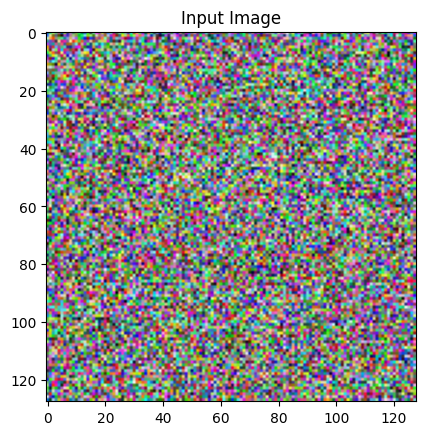

In [8]:

# 如果想从调整一张噪声图像开始，请用下面一行的代码
input_img = torch.randn(content_img.data.size())

if use_cuda:
    input_img = input_img.cuda()
    content_img = content_img.cuda()
    style_img = style_img.cuda()
# 将选中的待调整图打印出来:
plt.figure()
imshow(input_img.data, title='Input Image')


### 2. 优化输入的图像（训练过程）

正在构造风格迁移模型..
开始优化..
运行 0轮:
风格损失 : 27778.984375 内容损失: 24.737946

运行 50轮:
风格损失 : 12.451557 内容损失: 13.396454

运行 100轮:
风格损失 : 5.902695 内容损失: 11.292410

运行 150轮:
风格损失 : 4.229156 内容损失: 9.435043

运行 200轮:
风格损失 : 3.138558 内容损失: 8.233107

运行 250轮:
风格损失 : 2.356652 内容损失: 7.418933



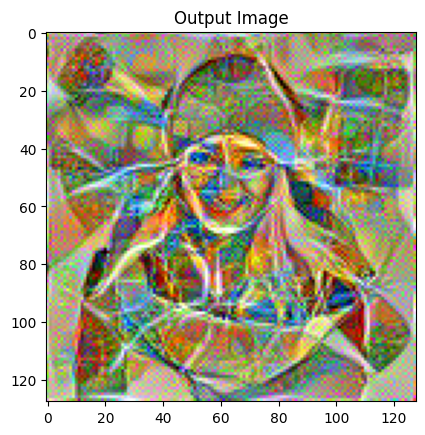

In [9]:
# 首先，需要先讲输入图像变成神经网络的参数，这样我们就可以用反向传播算法来调节这个输入图像了
input_param = nn.Parameter(input_img.data)

#定义个优化器，采用LBFGS优化算法来优化（试验效果很好，它的特点是可以计算大规模数据的梯度下降）
optimizer = optim.LBFGS([input_param])

# 迭代步数
num_steps=300


"""运行风格迁移的主算法过程."""
print('正在构造风格迁移模型..')

print('开始优化..')
for i in range(num_steps):
    #每一个训练周期
    
    # 限制输入图像的色彩取值范围在0-1间
    input_param.data.clamp_(0, 1)
    
    # 清空梯度
    optimizer.zero_grad()
    # 将图像输入构造的神经网络中
    model(input_param)
    style_score = 0
    content_score = 0
    
    # 每个损失函数层都开始反向传播算法
    for sl in style_losses:
        style_score += sl.backward()
    for cl in content_losses:
        content_score += cl.backward()

    # 每隔50个周期打印一次训练数据
    if i % 50 == 0:
        print("运行 {}轮:".format(i))
        print('风格损失 : {:4f} 内容损失: {:4f}'.format(
            style_score.data.item(), content_score.data.item()))
        print()
    def closure():
        return style_score + content_score
    #一步优化
    optimizer.step(closure)

# 做一些修正，防止数据超界...
output = input_param.data.clamp_(0, 1)

# 打印结果图
plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

本文件是集智学园http://campus.swarma.org 出品的“火炬上的深度学习”第IV课的配套源代码